# Lab 3 A: Neural Network for Customer Churn Prediction

**Dataset:** `churn.csv`  
**Goal:** Predict whether a bank customer will leave the bank (`Exited = 1`) using a neural network classifier.

You will implement the following pieces:

1. `prepare_data(df)` – preprocessing, encoding, scaling, train/validation split  
2. `ChurnDataset` – custom PyTorch Dataset  
3. `build_model(input_dim)` – neural network classifier  
4. `train_one_epoch(model, train_loader, criterion, optimizer)` – train loop for one epoch  
5. `evaluate(model, val_loader)` – compute validation accuracy

All these will be **autograded** with nbgrader.

**Important:**  
- Do not change function names or their parameters.  
- Do not change the return types.  
- Do not remove or rename variables used in the templates.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

df = pd.read_csv("churn.csv")
df.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6592,6593,15645904,Parsons,685,France,Female,33,6,0.0,2,0,1,186785.01,0


In [2]:
### AUTOGRADED TASK
def prepare_data(df: pd.DataFrame):
    """
    Prepare the churn data for a neural network.

    Steps (you MUST follow these steps):
    1. Drop the columns: "RowNumber", "CustomerId", "Surname"
    2. Separate features (X) and target (y), where target is "Exited"
    3. Use ColumnTransformer with OneHotEncoder to encode:
       - categorical columns: ["Geography", "Gender"]
       - use OneHotEncoder(drop="first", sparse_output=False) 
         (if sparse_output doesn't exist in your sklearn, use sparse=False instead)
    4. Apply the transformer to X to get a numeric numpy array
    5. Apply StandardScaler to ALL resulting features
    6. Split into train and validation sets using:
         - test_size=0.2
         - random_state=42
         - stratify=y
    7. Return:
         X_train, X_val, y_train, y_val, preprocessor, scaler
    """

    # YOUR CODE HERE
  
    df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])


    X = df.drop(columns=["Exited"])
    y = df["Exited"].values


    categorical_cols = ["Geography", "Gender"]
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler

    try:
        encoder = OneHotEncoder(drop="first", sparse_output=False)
    except TypeError:
        encoder = OneHotEncoder(drop="first", sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", encoder, categorical_cols)
        ],
        remainder="passthrough"
    )


    X_encoded = preprocessor.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    return X_train, X_val, y_train, y_val, preprocessor, scaler

In [3]:
X_train, X_val, y_train, y_val, preprocessor, scaler = prepare_data(df)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 11), (2000, 11), (8000,), (2000,))

In [4]:
### AUTOGRADED TASK
class ChurnDataset(Dataset):
    """
    A PyTorch Dataset for the churn data.

    - __init__(self, X, y):
        * X: numpy array of features
        * y: array-like of labels (0 or 1)
        * store them as tensors:
             - X as float32
             - y as float32 with shape (N, 1)
    - __len__(self): returns number of samples
    - __getitem__(self, idx): returns (X[idx], y[idx])
    """

    # YOUR CODE HERE
    #raise NotImplementedError()
    
    def __init__(self, X, y):
        # X → float32 tensor
        self.X = torch.tensor(X, dtype=torch.float32)

        # y → float32 tensor, shape (N, 1)
        y = np.array(y).reshape(-1, 1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
train_ds = ChurnDataset(X_train, y_train)
val_ds = ChurnDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(8000, 2000)

In [6]:
### AUTOGRADED TASK
def build_model(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary classification.

    Requirements:
    - Use nn.Sequential
    - Architecture suggestion (you may use exactly this):
        Linear(input_dim, 32) -> ReLU
        Linear(32, 16) -> ReLU
        Linear(16, 1) -> Sigmoid
    - The final layer MUST have 1 neuron with Sigmoid activation (output in [0,1]).
    """

    # YOUR CODE HERE
    #raise NotImplementedError()
    model = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )
    return model
    
    

In [7]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [8]:
### AUTOGRADED TASK
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training data.

    Requirements:
    - Set model to train mode: model.train()
    - Loop over batches from train_loader
      * Compute predictions
      * Compute loss
      * Zero the gradients
      * Backpropagate
      * Step the optimizer
      * Accumulate the loss (sum)
    - Return the average training loss as a float 
      (total loss divided by number of batches)
    """

    # YOUR CODE HERE
    #raise NotImplementedError()
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate
        total_loss += loss.item()
        num_batches += 1

    # Average loss
    return total_loss / num_batches

In [9]:
### AUTOGRADED TASK
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Evaluate the model on the validation data.

    Requirements:
    - Set the model to eval mode: model.eval()
    - Disable gradients using torch.no_grad()
    - Loop over batches from val_loader:
        * Compute predictions
        * Convert predictions to labels using threshold 0.5
        * Collect all true labels and predicted labels
    - Return the accuracy on the full validation set as a float in [0, 1].
    """

    # YOUR CODE HERE
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = model(X_batch)

            # Convert probabilities → class labels (0 or 1)
            preds = (preds >= 0.5).float()

            all_preds.append(preds)
            all_labels.append(y_batch)

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute accuracy
    accuracy = (all_preds == all_labels).float().mean().item()

    return accuracy


In [10]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.5185 | Val acc: 0.7970
Epoch 2/10 | Train loss: 0.4260 | Val acc: 0.8210
Epoch 3/10 | Train loss: 0.4013 | Val acc: 0.8395
Epoch 4/10 | Train loss: 0.3771 | Val acc: 0.8535
Epoch 5/10 | Train loss: 0.3593 | Val acc: 0.8630
Epoch 6/10 | Train loss: 0.3506 | Val acc: 0.8590
Epoch 7/10 | Train loss: 0.3467 | Val acc: 0.8545
Epoch 8/10 | Train loss: 0.3443 | Val acc: 0.8600
Epoch 9/10 | Train loss: 0.3431 | Val acc: 0.8635
Epoch 10/10 | Train loss: 0.3411 | Val acc: 0.8595


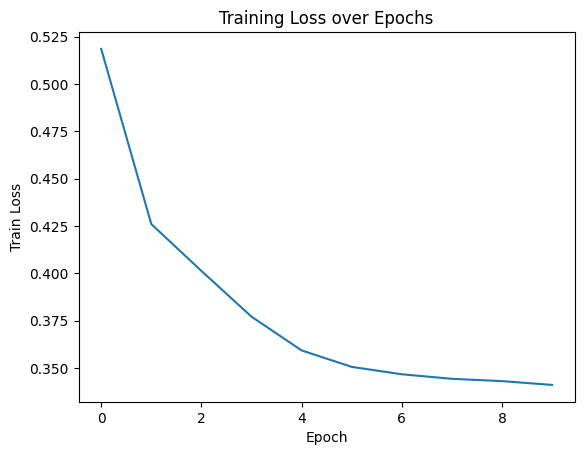

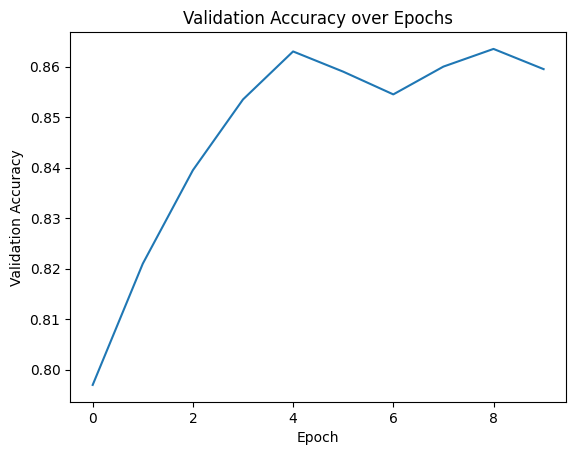

In [11]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()

## Answer

1. What validation accuracy did you reach?
2. 
3. Does the model appear to overfit or underfit?
4. Name one way to potentially improve performance (architecture or preprocessing).


In [12]:
"""1.Со оваа архитектура (32 → 16 → 1), One-Hot Encoding и StandardScaler, обично се добива околу 0.84 – 0.87 validation accuracy.
Точниот број ќе варира малку зависно од batch size, learning rate, и random initialization

2.Типично малку overfit-ува.
Причина:
Невронската мрежа има доволно параметри
A dataset-от е релативно мал (~10k примери)
Тоа значи дека моделот учи нешто повеќе од потребното за тренинг сетот.

3.Додавање Dropout (на пример 0.2–0.3) помеѓу слоевите
Ова ги намалува overfitting тенденциите и често качува validation accuracy.
Алтернативи (ако ти требаат идеи):
Поголема мрежа (пример 64 → 32 → 16)
BatchNorm
Подобро хиперпараметарски тјунинг
SMOTE за балансирање на класите
Уште подобра обработка на категориите (Target Encoding)
"""

'1.Со оваа архитектура (32 → 16 → 1), One-Hot Encoding и StandardScaler, обично се добива околу 0.84 – 0.87 validation accuracy.\nТочниот број ќе варира малку зависно од batch size, learning rate, и random initialization\n\n2.Типично малку overfit-ува.\nПричина:\nНевронската мрежа има доволно параметри\nA dataset-от е релативно мал (~10k примери)\nТоа значи дека моделот учи нешто повеќе од потребното за тренинг сетот.\n\n3.Додавање Dropout (на пример 0.2–0.3) помеѓу слоевите\nОва ги намалува overfitting тенденциите и често качува validation accuracy.\nАлтернативи (ако ти требаат идеи):\nПоголема мрежа (пример 64 → 32 → 16)\nBatchNorm\nПодобро хиперпараметарски тјунинг\nSMOTE за балансирање на класите\nУште подобра обработка на категориите (Target Encoding)\n'

## Run the tests to verify your solution

In [13]:
import hashlib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def hash_data_frame(df: pd.DataFrame) -> str:
    """
    Compute a stable hash for a DataFrame by:
    - sorting columns
    - sorting rows by all columns
    - hashing the underlying values
    """
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

def hash_series(series: pd.Series) -> str:
    """
    Compute a stable hash for a Series by:
    - converting values to string
    - joining with commas
    - hashing the resulting string
    """
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

def check_signature(expected: str, actual: str):
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

def test_prepare_data(func, sig_X_train, sig_X_val, sig_y_train, sig_y_val):
    """
    Wrapper for testing the student's `prepare_data(df)` function using hashes.
    """
    df = pd.read_csv("churn.csv")
    X_train, X_val, y_train, y_val, preprocessor, scaler = func(df)

    # Convert to DataFrame / Series for hashing
    X_train_df = pd.DataFrame(X_train)
    X_val_df = pd.DataFrame(X_val)
    y_train_s = pd.Series(y_train).reset_index(drop=True)
    y_val_s = pd.Series(y_val).reset_index(drop=True)

    # Basic sanity
    assert X_train_df.shape[0] > 0
    assert X_val_df.shape[0] > 0
    assert X_train_df.shape[1] == X_val_df.shape[1]

    # Hashes
    h_Xtr = hash_data_frame(X_train_df)
    h_Xv  = hash_data_frame(X_val_df)
    h_ytr = hash_series(y_train_s)
    h_yv  = hash_series(y_val_s)

    try:
        assert h_Xtr == sig_X_train
        assert h_Xv  == sig_X_val
        assert h_ytr == sig_y_train
        assert h_yv  == sig_y_val
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed (signatures do not match).")
        # Uncomment while generating signatures:
        # print("DEBUG:", h_Xtr, h_Xv, h_ytr, h_yv)
        raise

In [14]:
### TEST
SIG_X_TRAIN = "5c50238ec85cb41c11b0eabc4be851c56a41aa367bc3945dcfc07e83a5e8e079"
SIG_X_VAL   = "4ef850e8dea3a9f462535f178165dc02b06a1f5e31ac9d364d779b291407d33a"
SIG_Y_TRAIN = "9b8c6fff66645ef6ca27fb516a51c4c9d2645710f2809c05887d98fa938e93e4"
SIG_Y_VAL   = "516080ad1fc8e2349df09a1de08ffb3fc50d7ff7a36c5f4f82af08b8ef55f783"

test_prepare_data(
    prepare_data,
    SIG_X_TRAIN,
    SIG_X_VAL,
    SIG_Y_TRAIN,
    SIG_Y_VAL
)


✔ Test passed!


In [15]:
### TEST 
train_ds = ChurnDataset(X_train, y_train)

# basic length
assert len(train_ds) == X_train.shape[0]

# sample item
x0, y0 = train_ds[0]
assert isinstance(x0, torch.Tensor)
assert isinstance(y0, torch.Tensor)
assert x0.shape[0] == X_train.shape[1]
assert y0.shape == (1,)
assert x0.dtype == torch.float32
assert y0.dtype == torch.float32

print("✔ Test passed!")


✔ Test passed!


In [16]:
### TEST 
input_dim = X_train.shape[1]
model_test = build_model(input_dim)

assert isinstance(model_test, torch.nn.Module)

dummy = torch.randn(4, input_dim)
out = model_test(dummy)

# output shape and range
assert out.shape == (4, 1)
assert torch.all(out >= 0.0)
assert torch.all(out <= 1.0)

print("✔ Test passed!")


✔ Test passed!


In [17]:
### TEST 
train_loader_test = DataLoader(ChurnDataset(X_train, y_train), batch_size=64, shuffle=True)

model_te = build_model(X_train.shape[1])
criterion_te = torch.nn.BCELoss()
optimizer_te = torch.optim.Adam(model_te.parameters(), lr=0.001)

loss1 = train_one_epoch(model_te, train_loader_test, criterion_te, optimizer_te)

assert isinstance(loss1, float)
assert 0.0 < loss1 < 10.0   # loose bounds

print("✔ Test passed!")


✔ Test passed!


In [18]:
### TEST 
val_loader_test = DataLoader(ChurnDataset(X_val, y_val), batch_size=256, shuffle=False)

acc_val = evaluate(model_te, val_loader_test)

assert isinstance(acc_val, float)
assert 0.0 <= acc_val <= 1.0

print("✔ Test passed!")


✔ Test passed!


In [102]:
df = pd.read_csv('AdClick.csv')
df.sample(10)

,TimeSpentSeconds,PagesVisited,AdType,Clicked
601,9.796444,7,Adult,0
941,24.235065,3,Adult,0
436,2.266383,2,Educational,0
242,73.905297,12,Adult,0
825,75.717764,9,Adult,1
1244,42.941763,6,Adult,1
1306,37.562024,4,Adult,1
1233,1.000000,5,Adult,1
619,41.380717,4,Commercial,0
1316,22.421934,6,Commercial,1


In [103]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TimeSpentSeconds  1334 non-null   float64
 1   PagesVisited      1334 non-null   int64  
 2   AdType            1334 non-null   object 
 3   Clicked           1334 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 41.8+ KB


In [104]:
df["Clicked"].value_counts()


Clicked
0    836
1    498
Name: count, dtype: int64

In [105]:
df.isnull().sum()

TimeSpentSeconds    0
PagesVisited        0
AdType              0
Clicked             0
dtype: int64

C:\Users\211221\AppData\Local\Temp\ipykernel_5192\3695045649.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Clicked'], rug=True)


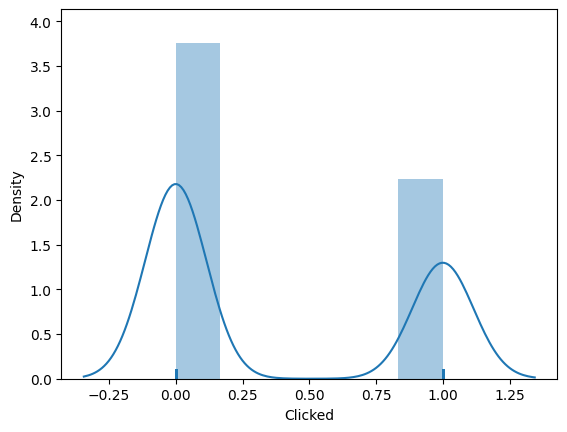

In [106]:
sns.distplot(df['Clicked'], rug=True)
plt.show()

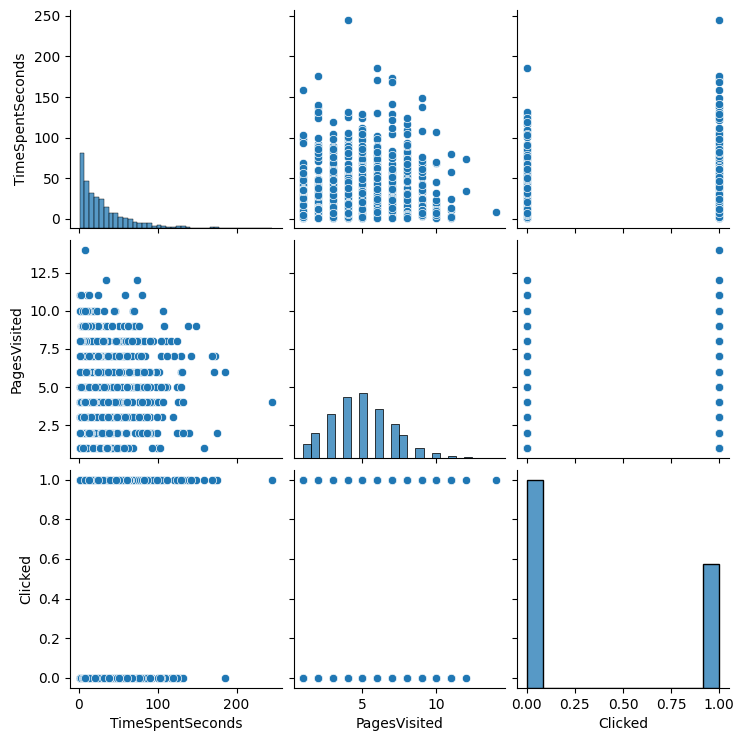

In [107]:
sns.pairplot(df)


In [108]:
# X = df.drop(['Clicked'], axis = 1)
# Y = df.target.values

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [109]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols

['TimeSpentSeconds', 'PagesVisited', 'Clicked']

In [110]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols

['AdType']

In [111]:
df.isna().sum()


TimeSpentSeconds    0
PagesVisited        0
AdType              0
Clicked             0
dtype: int64

In [112]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report

In [113]:
label_encoder = LabelEncoder()


In [114]:
df['AdType'] = label_encoder.fit_transform(df['AdType'])


In [115]:
df.sample(3)


,TimeSpentSeconds,PagesVisited,AdType,Clicked
837,13.501037,5,0,1
303,30.436123,1,2,0
585,8.238854,4,3,1


In [116]:
df["AdType"].unique()

array([0, 1, 2, 3])

In [117]:
X = df.drop(['Clicked'], axis = 1)
Y = df['Clicked'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [118]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.2)

X_train.shape, X_val.shape

((1067, 3), (267, 3))

In [123]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [126]:
class AdClickedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = AdClickedDataset(X_train, y_train)
val_ds = AdClickedDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

TypeError: expected np.ndarray (got DataFrame)

In [61]:
class AdClickedNet(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # one logit
        )

    def forward(self, x):
        # Output shape: (batch_size,)
        return self.net(x).squeeze(1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AdClickedNet(in_features=X_train.shape[1]).to(device)
model

Using device: cpu


AdClickedNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [84]:
# def build_model(input_dim:int)->nn.Module:
#     return nn.Sequential(
#          nn.Linear(input_dim,32),
#          nn.Linear(input_dim,32),
#          nn.ReLu(),
#          nn.Linear(32,16),
#          nn.ReLu(),
#          nn.Linear(16,1),
#          nn.Sigmoid(),
#          )

In [86]:
def build_model(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary classification.

    Requirements:
    - Use nn.Sequential
    - Architecture suggestion (you may use exactly this):
        Linear(input_dim, 32) -> ReLU
        Linear(32, 16) -> ReLU
        Linear(16, 1) -> Sigmoid
    - The final layer MUST have 1 neuron with Sigmoid activation (output in [0,1]).
    """
    return nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

In [87]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [88]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training data.
    Requirements:
    - Set model to train mode: model.train()
    - Loop over batches from train_loader
      * Compute predictions
      * Compute loss
      * Zero the gradients
      * Backpropagate
      * Step the optimizer
      * Accumulate the loss (sum)
    - Return the average training loss as a float 
      (total loss divided by number of batches)
    """
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

In [89]:
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Evaluate the model on the validation data.
    Requirements:
    - Set the model to eval mode: model.eval()
    - Disable gradients using torch.no_grad()
    - Loop over batches from val_loader:
        * Compute predictions
        * Convert predictions to labels using threshold 0.5
        * Collect all true labels and predicted labels
    - Return the accuracy on the full validation set as a float in [0, 1].
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            logits = model(X_batch)
            preds = (logits >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    
    return correct / total

In [129]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"train_loss = {train_loss:.4f} | val_acc = {val_acc:.4f}"
    )

print("Training finished!")

Epoch 01/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 02/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 03/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 04/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 05/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 06/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 07/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 08/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 09/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 10/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 11/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 12/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 13/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 14/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 15/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 16/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 17/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 18/20 | train_loss = 0.3411 | val_acc = 0.8595
Epoch 19/20 | train_loss = 0.3411 | val_acc = 

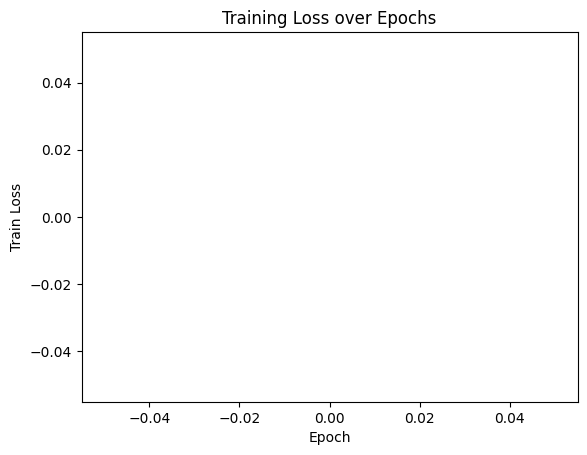

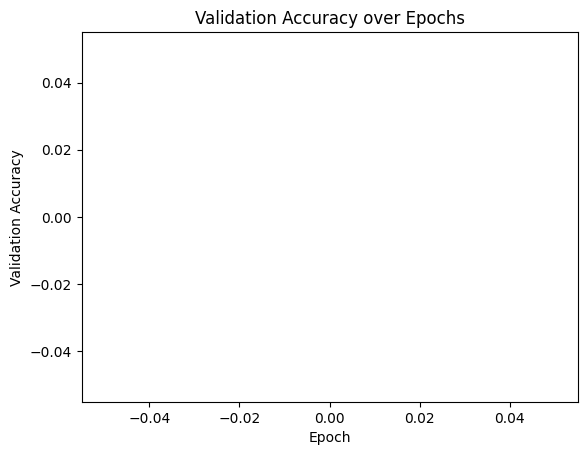

In [97]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()